# Data Scientist Professional Practical Exam Submission
Use this template to write up your summary for submission. Code in Python or R needs to be included.

In [4]:
import numpy as np
import pandas as pd
import math 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Import the Data

In [5]:
df = pd.read_csv('recipe_site_traffic_2212.csv')
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


# Data Validation:
The original dataset has 947 rows and 8 columns. After validating the data on each column, I made some changes as below.

1) Recipe: 947 unique values without missing values, similar to the description. After data cleaning, 52 rows were removed because of the missing values from other columns.
2) Calories: 895 non-null values, similar to the description. 52 missing values were replaced by the average value of the "calories" column grouped by "category" and "servings".
3) Carbohydrate: 895 non-null values, similar to the description. 52 missing values were replaced by the average value of the "carbohydrate" column grouped by "category" and "servings".
4) Sugar: 895 non-null values, similar to the description. 52 missing values were replaced by the average value of the "sugar" column grouped by "category" and "servings".
5) Protein: 895 non-null values, similar to the description. 52 missing values were replaced by the average value of the "protein" column grouped by "category" and "servings".
6) Category: 11 unique categories without missing values instead of 10 categories provided by the description. I merged category "Chicken Breast" into category "Chicken" because they belong to the same category.
7) Servings: 6 unique categories without missing values. According to the description, "servings" must be a numeric column, not a character column. Two extra categories "4 as a snack" and "6 as a snack" were merged into "4" and "6", respectively. The column type was changed to integer.
8) High-traffic: 1 non-null values, similar to the description. 373 missing values were replaced with "0".

# Data Cleaning:
1) Remove rows with null values in calories, carbohydrate, sugar, protein to maintain data integrity.
2) Category: "Chicken Breast" category was united with the "Chicken" category to ensure consistency.
3) Servings: Extra values "4 as a snack" and "6 as a snack" were united with "4" and "6", respectively, and the column type was changed to integer.
4) High-traffic: Replace null values with "0".

Furthermore, I created four more columns that illustate the total nutrients of each recipe. After validating and cleaning, the dataset has 895 rows and 11 columns.

## Clean and Prepare Data 

In [6]:
# Check size of dataset
df.shape
print("The dataset has {} rows and {} columns.".format(df.shape[0],df.shape[1]))

The dataset has 947 rows and 8 columns.


In [7]:
# Overview the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


* The dataset has 8 columns: recipe, calories, carbohydrate, sugar, protein, category, servings, and high_traffic.
* Numerical columns: recipe, calories, carbohydrate, sugar, protein.
* Categorical columns: category, servings, high_traffic.

In [8]:
# Number of missing values in each columns
df.isnull().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

In [9]:
# Number of unique value of categorical columns
num_unique_objects = df.select_dtypes(include='object').nunique()
unique_values = df.select_dtypes(include='object').apply(lambda x: x.unique())
num_unique_objects,unique_values

(category        11
 servings         6
 high_traffic     1
 dtype: int64,
 category        [Pork, Potato, Breakfast, Beverages, One Dish ...
 servings                 [6, 4, 1, 2, 4 as a snack, 6 as a snack]
 high_traffic                                          [High, nan]
 dtype: object)

* Category has 11 unique categories instead of 10 according to the description.
* Servings has 6 unique categories and has inconsistent data.
* High_traffic has 1 unique categories and has missing values.

## Preparation of categorical variables

In [10]:
# The "servings" column has values encoded in different ways, although there are no null values.
print(df.servings.value_counts())
# Replacing similar values
df.servings = df.servings.str.replace(' as a snack','')

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64


In [11]:
# "high_traffic" has nul values (373), but it is clear that this values is not interesting for us, so i replace null value as "0" and "High" as 1
print(df.high_traffic.value_counts(dropna=False))
df.high_traffic.replace('High',1, inplace=True)
df.high_traffic.fillna(0,inplace=True)

High    574
NaN     373
Name: high_traffic, dtype: int64


In [12]:
# The column "category" does not have null values, however, it is possible to combine the values "Chicken Breast" with "Chicken", since they belong to the same category
print(df.category.value_counts())
df.category.replace('Chicken Breast','Chicken', inplace=True)

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64


## Preparation of Numerical variables



In [13]:
df.loc[df.calories.isnull()]

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,1.0
23,24,NaN,NaN,NaN,NaN,Meat,2,0.0
48,49,NaN,NaN,NaN,NaN,Chicken,4,0.0
82,83,NaN,NaN,NaN,NaN,Meat,4,1.0
89,90,NaN,NaN,NaN,NaN,Pork,6,1.0
116,117,NaN,NaN,NaN,NaN,Chicken,6,1.0
121,122,NaN,NaN,NaN,NaN,Dessert,2,1.0
136,137,NaN,NaN,NaN,NaN,One Dish Meal,2,1.0
149,150,NaN,NaN,NaN,NaN,Potato,2,1.0
187,188,NaN,NaN,NaN,NaN,Pork,4,1.0


Viewing the null values of numerical variables showed that all 52 omissions relate to the same recipes, therefore, in order not to lose observations, it was decided to fill in the data with an average value for groups based on the columns "category" and "servings"

In [14]:
df_gr = df.groupby(['category', 'servings'])[["calories",'carbohydrate','sugar', 'protein']].mean()
for i in df.columns[1:5]:
    for j in df.index:
        if math.isnan(df[i][j]):
            df[i][j] = round(df_gr.loc[(df.category[j], df.servings[j])][i],2)      

## Remove column Recipe:

I will drop column recipe because it just the ID of the recipe and won't help us with further analysis.

In [15]:
# Remove column Recipe
df.drop('recipe',axis=1,inplace=True)

## Check negative number:

In [16]:
df.describe()

,calories,carbohydrate,sugar,protein,high_traffic
count,947.000000,947.000000,947.000000,947.000000,947.000000
mean,439.825702,35.121911,9.064498,24.577402,0.606125
std,442.246014,42.905695,14.447589,35.764049,0.488866
min,0.140000,0.030000,0.010000,0.000000,0.000000
25%,114.410000,9.135000,1.795000,3.465000,0.000000
50%,306.900000,22.330000,4.930000,11.240000,1.000000
75%,594.475000,44.740000,9.565000,32.360000,1.000000
max,3633.160000,530.420000,148.750000,363.360000,1.000000


The dataset doesn't have any negative values.

# Exploratory Analysis
The product manager wants us to predict the high traffic recipe. Therefore, I choose high_traffic column as the target variable.

- ## Target variable: High traffic

In [17]:
plt.style.use('seaborn-v0_8')

Text(0.5, 1.0, 'The ratio of recipes by high traffic')

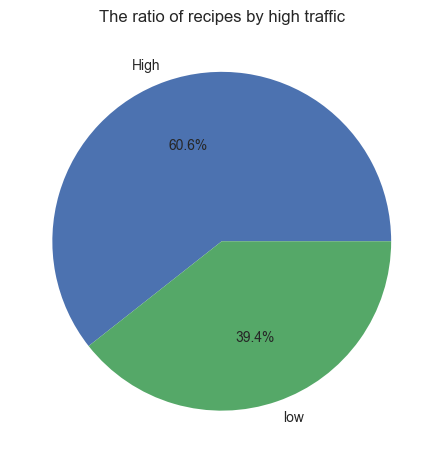

In [18]:
# Distribution schedule for high traffic
fig, ax = plt.subplots()
ax.pie(df["high_traffic"].value_counts(), labels=['High','low'], autopct='%1.1f%%')
plt.title('The ratio of recipes by high traffic')

In [19]:
# Calculate number of high, low traffic recipes
high, low = df['high_traffic'].value_counts()

print('Number of recipe labeled as high:',high)
print('Number of recipe labeled as low:', low)

Number of recipe labeled as high: 574
Number of recipe labeled as low: 373


* According to the graph above, there are 574 recipes labeled as high traffic account for 60.6%, while there are 373 recipes labeled as low traffic taking up 39.4%.
* The high-traffic recipes are higher than the low-traffic recipes.

## Categorical variables

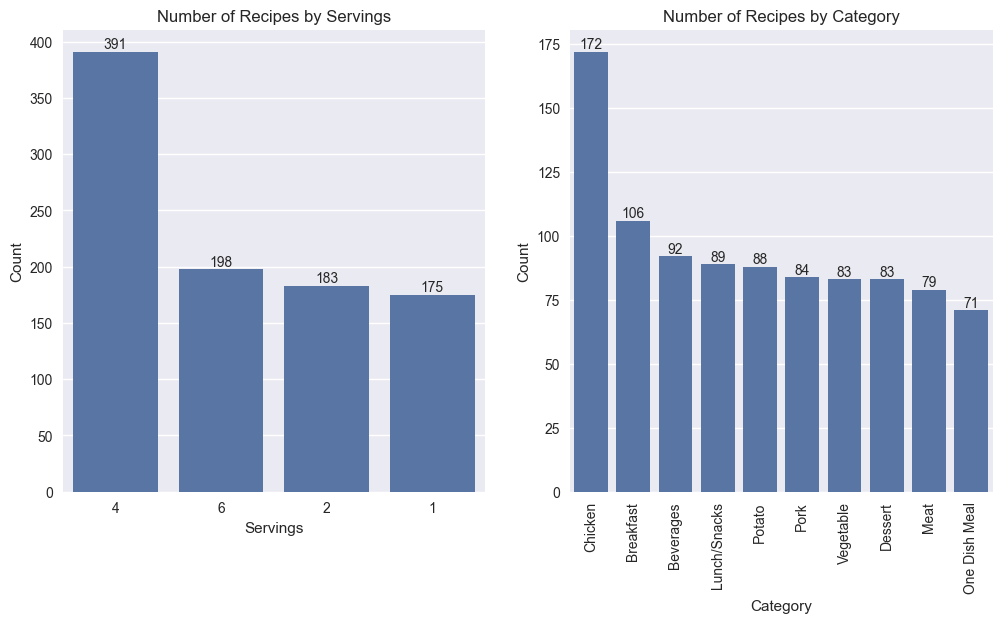

In [20]:
fig, axes = plt.subplots(1,2,figsize=(12,6))

# Countplot for servings
sns.countplot(data=df, x='servings',ax=axes[0], order=df["servings"].value_counts().index)
for i in range(0,len(df["servings"].value_counts())):
    axes[0].text(i, df["servings"].value_counts()[i], str(df["servings"].value_counts()[i]), ha='center', va='bottom')

axes[0].set_title('Number of Recipes by Servings')
axes[0].set_xlabel("Servings")
axes[0].set_ylabel("Count")

# Countplot for category
sns.countplot(data=df, x='category',ax=axes[1], order=df["category"].value_counts().index)
for i in range(0,len(df["category"].value_counts())):
    axes[1].text(i, df["category"].value_counts()[i], str(df["category"].value_counts()[i]), ha='center', va='bottom')

axes[1].set_title('Number of Recipes by Category')
axes[1].set_xlabel("Category")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=90)

The graphs above illustrate the distribution of servings and categories in the dataset.

* Servings: The majority of recipes (approximately 60%) are served for four people, while the number of recipes served for one, two, and six people are almost the same.
* Categories: The most common category in the dataset is chicken, accounting for a significant portion of the recipes.

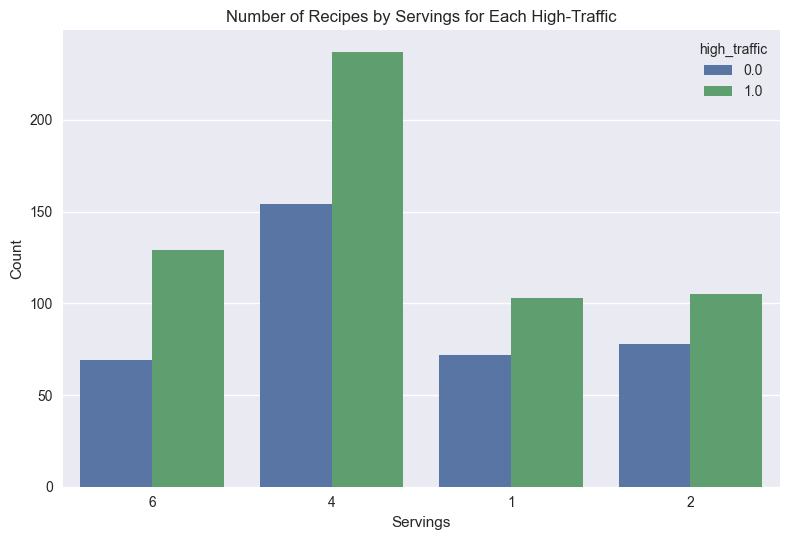

In [21]:
fig, ax = plt.subplots()
# Countplot for servings for each high-traffic
ax.set_title("Number of Recipes by Servings for Each High-Traffic")
ax.set_xlabel("Servings")
ax.set_ylabel("Count")
sns.countplot(data=df, x="servings", hue="high_traffic", ax=ax)

plt.tight_layout()
plt.show()

For each of servings, the amount of recipes with high traffic is higher than the amount of recipes with low traffic. No significant correlation between servings and high_traffic is seen.

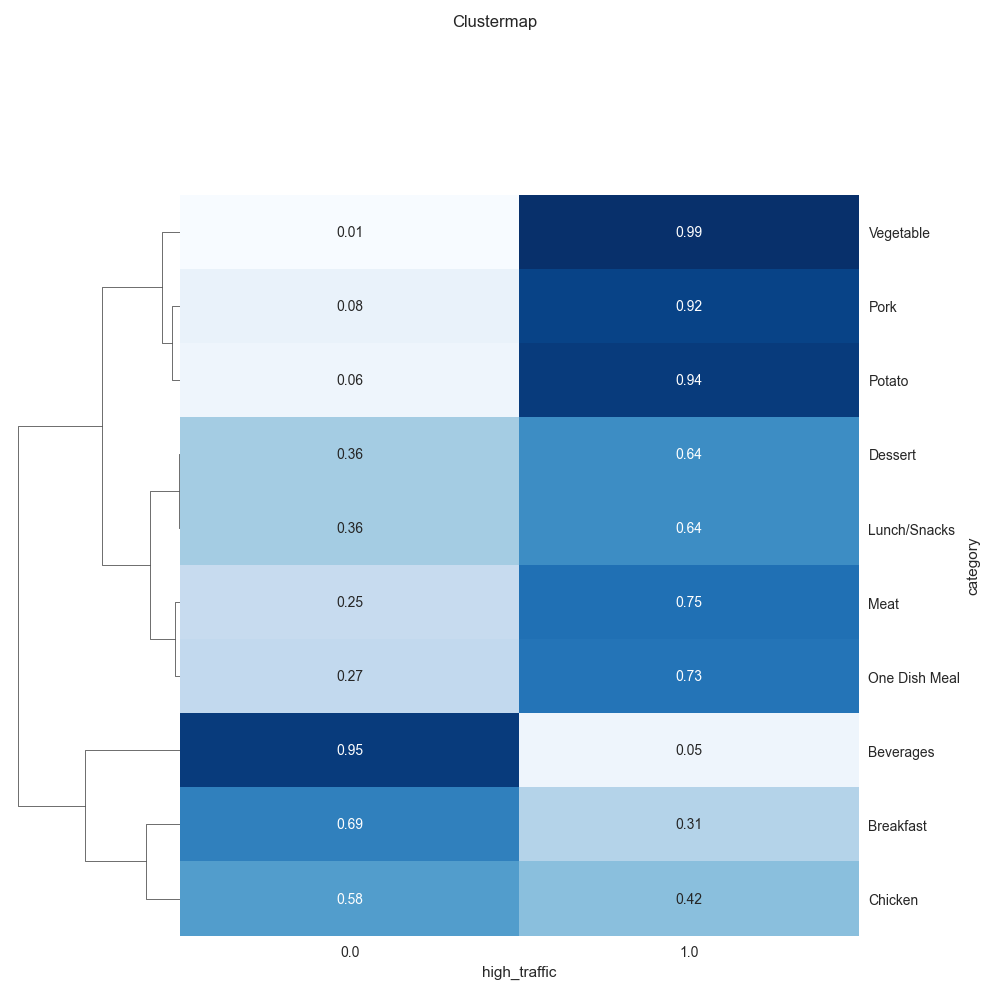

In [22]:
# Create crosstab between the high_traffic and category
df_crosstab = pd.crosstab(df.category, df.high_traffic, normalize='index')
g = sns.clustermap(df_crosstab, annot=True, cmap='Blues', fmt=".2f", col_cluster=False, cbar=False, cbar_pos=None)
g.fig.suptitle('Clustermap')
plt.show()

Except for three categories (Chicken, Breakfast and Beverages), seven categories remain always have the high-traffic recipes higher than the low-traffic recipes. Potato, Vegetable, Pork are the highest in high traffic recipes. The category can influence high-traffic.

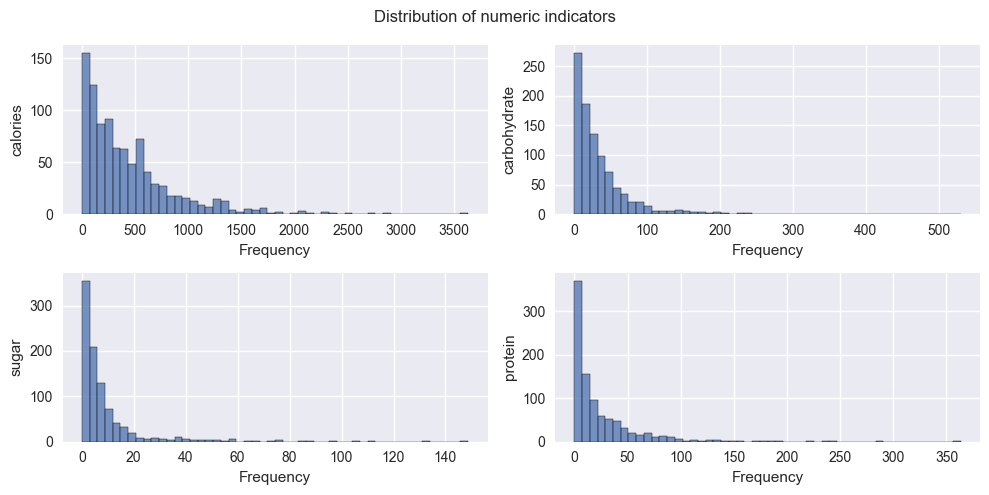

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
sns.histplot(df['calories'], bins=50, ax = axes[0,0]).set(xlabel="Frequency",ylabel="calories")
sns.histplot(df['carbohydrate'], bins=50, ax=axes[0,1]).set(xlabel="Frequency",ylabel="carbohydrate")
sns.histplot(df['sugar'], bins=50, ax=axes[1,0]).set(xlabel="Frequency",ylabel="sugar")
sns.histplot(df['protein'], bins=50, ax=axes[1,1]).set(xlabel="Frequency",ylabel="protein")

# Add a titles to the charts
fig.suptitle('Distribution of numeric indicators')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

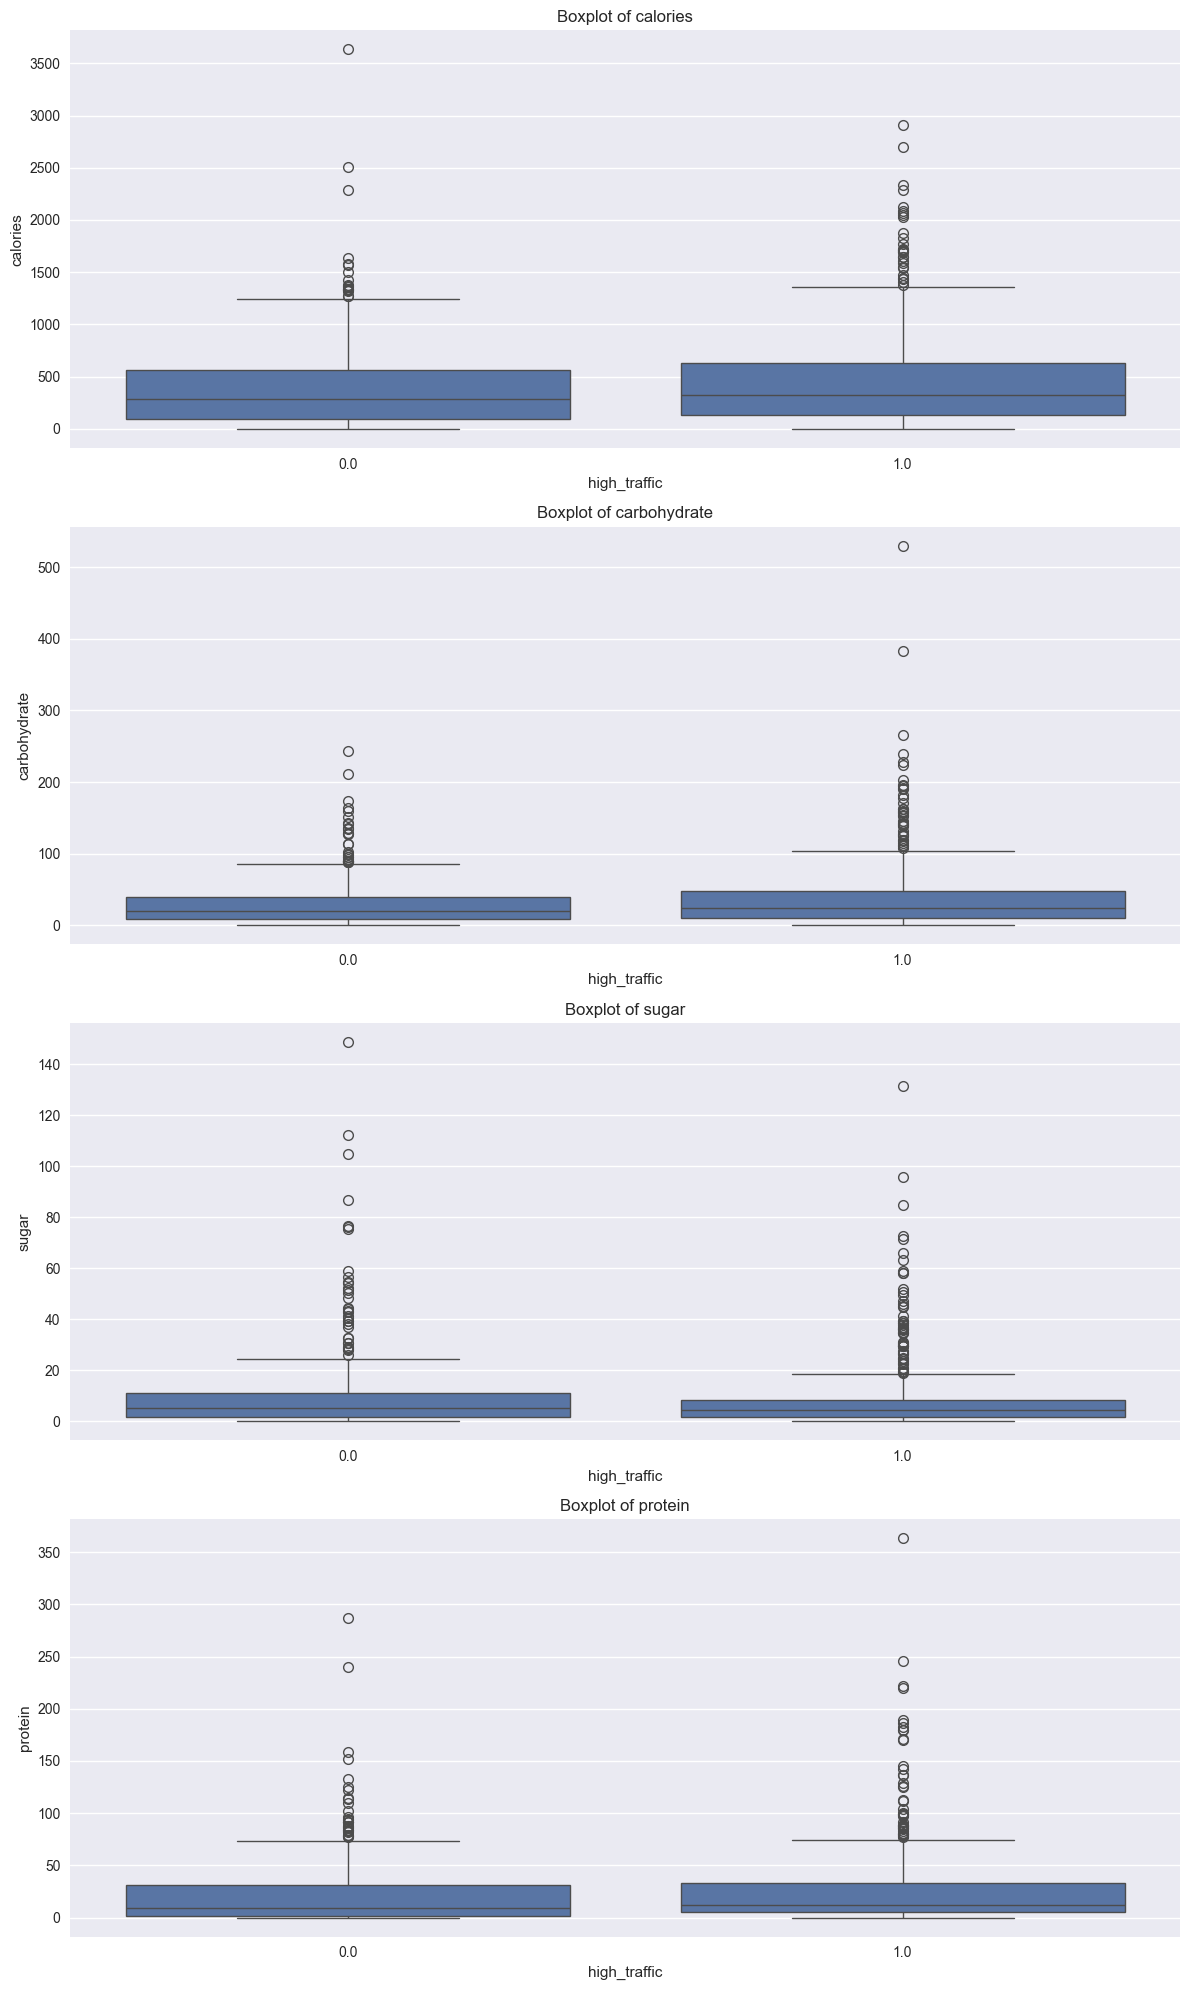

In [24]:
# Create a figure with two subplots
fig, axs = plt.subplots(4, 1, figsize=(12, 20))

# Plot the overlais histogram on the first subplot
sns.boxplot(data=df, x="high_traffic", y="calories", orient="v", ax=axs[0])
axs[0].set_title('Boxplot of calories')
sns.boxplot(data=df, x="high_traffic", y="carbohydrate", orient="v", ax=axs[1])
axs[1].set_title('Boxplot of carbohydrate')
sns.boxplot(data=df, x="high_traffic", y="sugar", orient="v", ax=axs[2])
axs[2].set_title('Boxplot of sugar')
sns.boxplot(data=df, x="high_traffic", y="protein", orient="v", ax=axs[3])
axs[3].set_title('Boxplot of protein')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

As we can see from the graph above, there are no major differences in nutrient distribution between the recipe with high-traffic and the recipe with low-traffic.

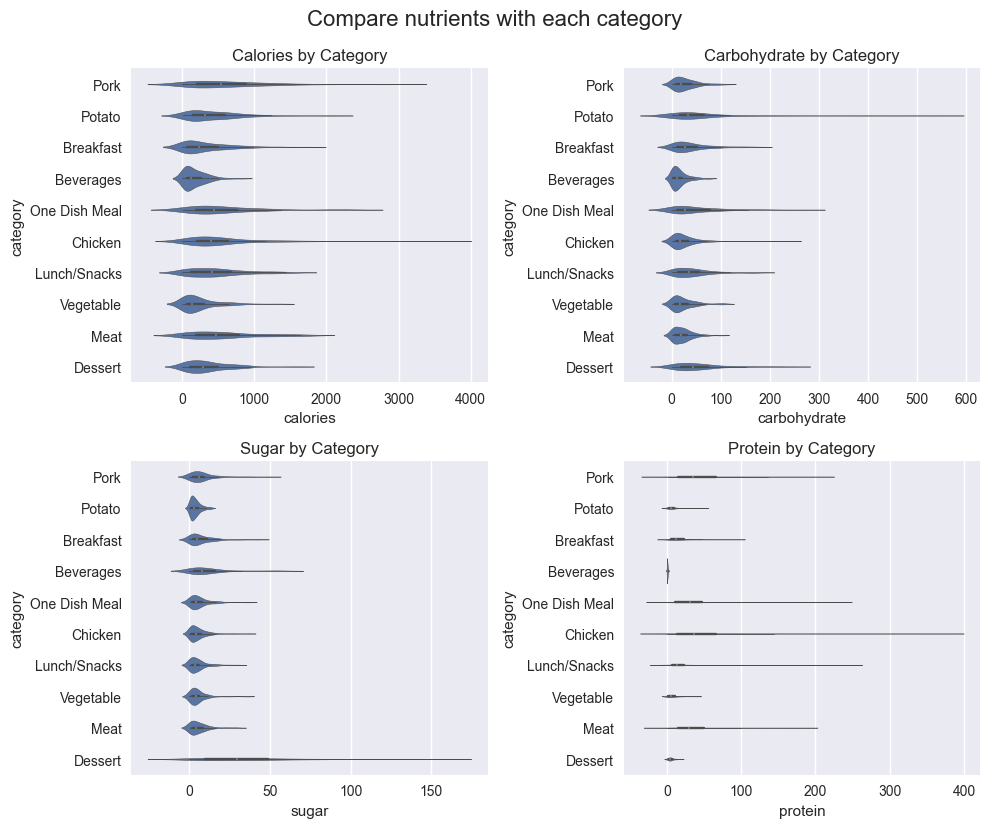

In [25]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Violinplot for calories by category
sns.violinplot(data=df, y="category", x="calories", ax=axes[0, 0])
axes[0, 0].set_title("Calories by Category")

# Violinplot for carbohydrate by category
sns.violinplot(data=df, y="category", x="carbohydrate", ax=axes[0, 1])
axes[0, 1].set_title("Carbohydrate by Category")

# Violinplot for sugar by category
sns.violinplot(data=df, y="category", x="sugar", ax=axes[1, 0])
axes[1, 0].set_title("Sugar by Category")

# Violinplot for protein by category
sns.violinplot(data=df, y="category", x="protein", ax=axes[1, 1])
axes[1, 1].set_title("Protein by Category")

# Adjust the layout and create suptitle
plt.tight_layout()
fig.suptitle('Compare nutrients with each category',y=1.03,fontsize=16)

# Show the plot
plt.show()

1) The category that contains the highest level of calories is Chicken then Pork and One Dish Meal.
2) The category that contains the highest level of carbohydrate is Potato.
3) The category that contains the highest level of sugar is Dessert.
4) The category that contains the highest level of protein is Chicken then One Dish Meal, Pork, Lunch/Snacks and Meat.

# Model Development:
## Predicting the high traffic is a binary classification problem. I decide to select two models:

* Baseline model: I choose Logistic Regression (which is a popular and widely used algorithm for binary classification tasks due to its simplicity, interpretability, and effectiveness in many real-world scenarios)
* Comparison model: I select Linear SVC (which is a type of Support Vector Machine algorithm used for classification tasks)


## Preprocessing model:
Before starting the analysis, I did some preprocessing steps:



## Select features and target variables.

* Features: I choose column calories, carbohydrate, sugar, protein, category and servings as features.
* Target: Because we want to predict the high-traffic recipes therefore I choose High_traffic column as the target.

In [26]:
# Features = X
X = df.loc[:,~df.columns.isin(['recipe','high_traffic'])]
# Target = y
y= df.loc[:,df.columns == 'high_traffic']

## Split the data into training set and test set.
I split the dataset into 67% of training set and 33% of test set.


In [27]:
# split the data with 33% test size
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

## Normalized the numerical variables in features.

Convert categorical columns to numeric columns.

In [28]:
# Normalize the data
scaler = StandardScaler()
x_train[['calories','carbohydrate','sugar','protein']] = scaler.fit_transform(x_train[['calories','carbohydrate','sugar','protein']])
x_test[['calories','carbohydrate','sugar','protein']] = scaler.transform(x_test[['calories','carbohydrate','sugar','protein']])

In [29]:
# Label the category column
encode = LabelEncoder()
x_train['category'] = encode.fit_transform(x_train['category'])
x_test['category'] = encode.transform(x_test['category'])

# The category after label encoder
label_category = dict(zip(encode.classes_,range(len(encode.classes_))))
label_category

{'Beverages': 0,
 'Breakfast': 1,
 'Chicken': 2,
 'Dessert': 3,
 'Lunch/Snacks': 4,
 'Meat': 5,
 'One Dish Meal': 6,
 'Pork': 7,
 'Potato': 8,
 'Vegetable': 9}

# Baseline model: Logistic Regression
In addition to building the module, I use the GridSearchCV library to achieve better accuracy based on the selection of the best hyperparameter interation

In [30]:
x_train

,calories,carbohydrate,sugar,protein,category,servings
602,-0.851495,-0.084912,-0.357903,0.633806,2,2
517,-0.454220,-0.583018,-0.242579,-0.649082,9,4
904,0.036292,1.503990,-0.320835,-0.506991,7,2
386,-0.766280,0.625829,0.428770,-0.207081,1,4
628,0.651186,-0.718420,-0.492447,-0.396084,6,6
...,...,...,...,...,...,...
13,-0.911016,-0.563710,0.071815,-0.425912,9,4
907,4.243647,-0.662451,-0.388107,0.245496,6,1
220,0.430730,-0.273596,0.186453,0.013920,1,2
919,1.598785,-0.591572,-0.245325,0.150588,5,6


In [31]:
# Create a Logistic Regression model
Log_reg = LogisticRegression()
# Define hyperparameter grid for Logistic Regression
parameters_Log_reg = {'C':np.logspace(-3,3,7),                 
           'penalty':['l1','l2','elasticnet',None],  
           'multi_class':['auto','ovr','multinomial'],
           'max_iter': [50,100,150,200]} 
    
    # C: Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
    # penalty: regularization penalty to be used
    # multi_class: strategy for handling multiple classes
    # max_iter: Maximum number of iterations taken for the solvers to converge.
    
# Perform GridSearchCV with 5 folds  
grid_Log_reg = GridSearchCV(Log_reg, parameters_Log_reg, cv=5)

# Fit the model
grid_Log_reg.fit(x_train,y_train)

# Parametrs of the best model
print('The best hyperparameter for Logisric Regression: ',grid_Log_reg.best_params_)

The best hyperparameter for Logisric Regression:  {'C': 0.001, 'max_iter': 50, 'multi_class': 'multinomial', 'penalty': 'l2'}


In [32]:
# Create a Logistic Regression model with the hyperparameters founded:
Log_reg = LogisticRegression( C = 0.001, max_iter = 50, multi_class = 'multinomial', penalty = 'l2').fit(x_train, y_train)
y_pred_Log_reg = Log_reg.predict(x_test)
print('The Accuracy for Test Set is {}'.format(round(accuracy_score(y_test, y_pred_Log_reg),2)))

The Accuracy for Test Set is 0.75


# Comparison model: Linear SVC
Apply the same workflow as I did for Logistic Regression.

In [33]:
# Create a Linear SVC model
SVC = LinearSVC()
# Define hyperparameter grid for Linear SVC
parameters_svc = {'C':np.logspace(-3,3,7),                 
           'penalty':['l1','l2'],  
           'loss':['hinge','squared_hinge'],
           'max_iter': [50,100,150,200]} 
    
    # C: The strength of the regularization is inversely proportional to C.
    # penalty: regularization penalty to be used
    # Loss: Specifies the loss function. ‘hinge’ is the standard SVM loss (used e.g. by the SVC class) while ‘squared_hinge’ is the square of the hinge loss.
    # max_iter: The maximum number of iterations to be run.
    
# Perform GridSearchCV with 5 folds  
grid_svc = GridSearchCV(SVC, parameters_svc, cv=5)

# Fit the model
grid_svc.fit(x_train,y_train)

# Parametrs of the best model
print('The best hyperparameter for Logisric Regression: ',grid_svc.best_params_)

The best hyperparameter for Logisric Regression:  {'C': 1.0, 'loss': 'hinge', 'max_iter': 200, 'penalty': 'l2'}


In [34]:
# Create a SVC model with the hyperparameters founded:
SVC = LinearSVC(C = 0.01, max_iter = 50, loss = 'squared_hinge', penalty = 'l2').fit(x_train, y_train)
y_pred_SVC = SVC.predict(x_test)
print('The Accuracy for Test Set is {}'.format(round(accuracy_score(y_test, y_pred_SVC),2)))

The Accuracy for Test Set is 0.73


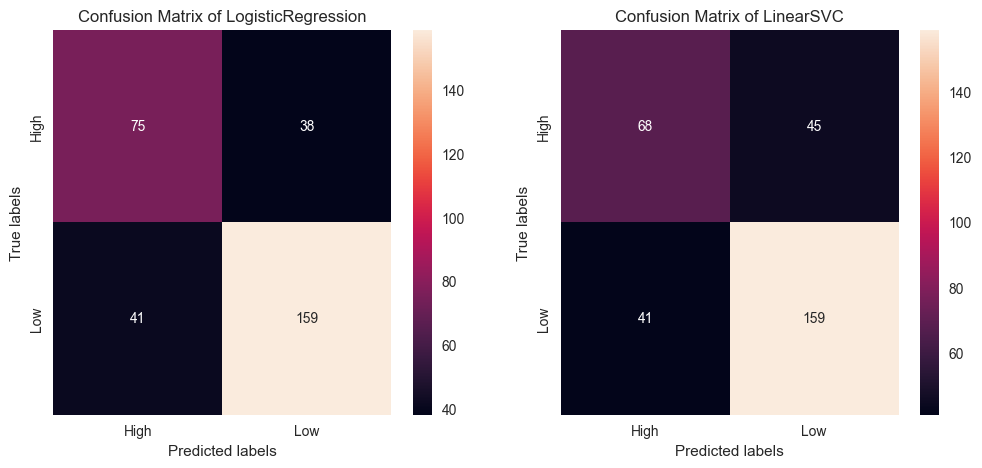

In [35]:
# Confusion Matrixs for the models
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_Log_reg), annot=True, fmt='g', ax=ax[0]);  
sns.heatmap(confusion_matrix(y_test, y_pred_SVC), annot=True, fmt='g', ax=ax[1]);  

# labels, title and ticks
ax[0].set_xlabel('Predicted labels');
ax[0].set_ylabel('True labels'); 
ax[0].set_title('Confusion Matrix of LogisticRegression'); 
ax[0].xaxis.set_ticklabels(['High', 'Low']); 
ax[0].yaxis.set_ticklabels(['High', 'Low']);

ax[1].set_xlabel('Predicted labels');
ax[1].set_ylabel('True labels'); 
ax[1].set_title('Confusion Matrix of LinearSVC'); 
ax[1].xaxis.set_ticklabels(['High', 'Low']); 
ax[1].yaxis.set_ticklabels(['High', 'Low']);

# Model Evaluation:
For this classification problem, I choose three metrics to evaluate the model performance.

Precision: measures the proportion of correctly predicted positive instances out of the total instances predicted as positive.
Recall: measures the proportion of correctly predicted positive instances out of the total actual positive instances.
F1-Score: the harmonic mean of precision and recall. Therefore, gives us a balanced measure of both precision and recall.
Three metrics have range from 0 to 1. The closer to 1, the better.

By considering these metrics, we can better assess the performance of the model in predicting high-traffic recipes accurately.

In [36]:
# Classification report of Logistic Regression:
print('Classification report of Baseline model - Logistic Regression: ')
print(classification_report(y_test,y_pred_Log_reg))

Classification report of Baseline model - Logistic Regression: 
              precision    recall  f1-score   support

         0.0       0.65      0.66      0.66       113
         1.0       0.81      0.80      0.80       200

    accuracy                           0.75       313
   macro avg       0.73      0.73      0.73       313
weighted avg       0.75      0.75      0.75       313



We want to predict the high-traffic recipe (which is labeled as 1 from the replacing step) so we will focus on precision, recall and F1-score of value 1.

The precision, recall and F1-score of Logistic Regression are 0.81, 0.80 and 0.80, respectively.

In [38]:
# Classification report of LinearSVC:
print('Classification report of Comparison model - LinearSVC: ')
print(classification_report(y_test,y_pred_SVC))

Classification report of Comparison model - LinearSVC: 
              precision    recall  f1-score   support

         0.0       0.62      0.60      0.61       113
         1.0       0.78      0.80      0.79       200

    accuracy                           0.73       313
   macro avg       0.70      0.70      0.70       313
weighted avg       0.72      0.73      0.72       313



Meanwhile, the precision, recall and F1-score of LinearSVC are 0.78, 0.8 and 0.79, respectively.

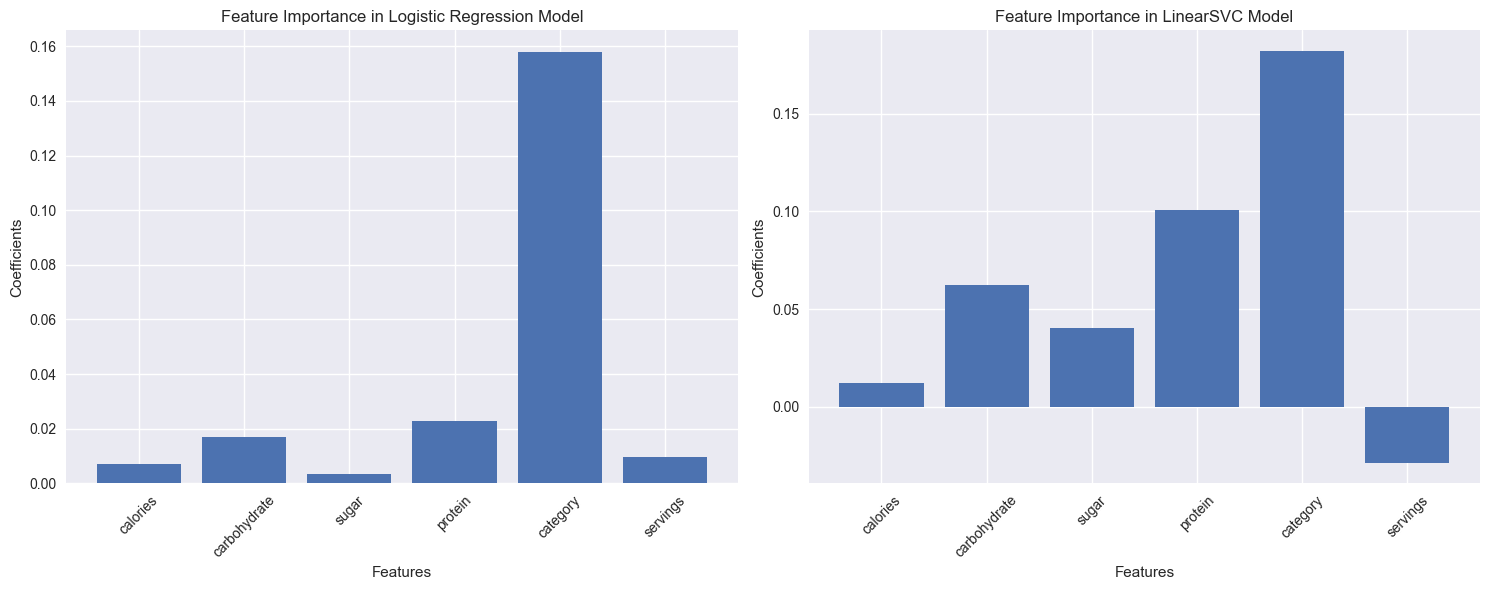

In [40]:
# Get the coefficients and column names
coefficients_lr = Log_reg.coef_[0]
coefficients_svc = SVC.coef_[0]
columns = X.columns

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot the bar chart for Logistic Regression
axs[0].bar(columns, coefficients_lr)
axs[0].set_xlabel('Features')
axs[0].set_ylabel('Coefficients')
axs[0].set_title('Feature Importance in Logistic Regression Model')
axs[0].tick_params(axis='x', rotation=45)

# Plot the bar chart for LinearSVC
axs[1].bar(columns, coefficients_svc)
axs[1].set_xlabel('Features')
axs[1].set_ylabel('Coefficients')
axs[1].set_title('Feature Importance in LinearSVC Model')
axs[1].tick_params(axis='x', rotation=45)

# Display the subplots
plt.tight_layout()
plt.show()

## CONCLUSION:
Both the Logistic Regression model and LinearSVC model worked well with the dataset.
Both models let us know that the category is the most effective feature for the high traffic.
The LinearSVC model gives a slightly worse result, however, according to the importance of variables, it can be understood that the variable "servings" does not play a key role and removing this variable from the model can improve the result

# Check the predictive model

Now I use the predictive Logistic Regression model to test. I randomly select a recipe from the test set and use its features as input to the model.

In [60]:
import random
random.seed(25)
random_recipe_index = random.randint(0, len(x_test) - 1)
random_recipe_features = x_test.iloc[random_recipe_index]

# Reshape the features to match the model's input shape
random_recipe_features = random_recipe_features.values.reshape(1, -1)

# Make the prediction using the Logistic Regression model
predicted_traffic = Log_reg.predict(random_recipe_features)[0]
if predicted_traffic == 1:
    predicted_traffic_category = "High"
else:
    predicted_traffic_category = "Low"

# Get the actual traffic category from the test set
actual_traffic = y_test.iloc[random_recipe_index][0]
if actual_traffic == 1:
    actual_traffic_category = "High"
else:
    actual_traffic_category = "Low"

# Print the results
print("Predicted Traffic Category: ", predicted_traffic_category)
print("Actual Traffic Category: ", actual_traffic_category)

Predicted Traffic Category:  High
Actual Traffic Category:  High


## Business Focus:
There are two primary business goals for this project:

Predict which recipes will have high-traffic.
Predict the recipes high-traffic with at least 80% probability.
CONCLUSION:

According to the results from the above steps, the Logistic Regression satisfied both business goals. Its precision, recall and F1-score have values equal to or greater than 80%.

## Business Metrics:
The Tasty Bytes wants to increase the accuracy of predicting high-traffic.

Therefore, we would consider using the accuracy of predictions that predicted high traffic as a KPI to compare two models performance with the business criteria. The model that has a higher accuracy score will perform better.

In [61]:
# Accuracy score of Logistic Regression:
test_accuracy_Log_reg = accuracy_score(y_test,y_pred_Log_reg)

# Accuracy score of LinearSVC:
test_accuracy_svc = accuracy_score(y_test, y_pred_SVC)

print("Accuracy score when using Logistic Regression: ", test_accuracy_Log_reg)
print("Accuracy score when using Linear SVC: ", test_accuracy_svc)

Accuracy score when using Logistic Regression:  0.7476038338658147
Accuracy score when using Linear SVC:  0.7252396166134185


## CONCLUSION:

Upon evaluation, the Logistic Regression model achieved an accuracy of 75%, while the Linear SVC model had a slightly lower accuracy of 73%.

# FINAL SUMMARY:
The Logistic Regression model outperforms the Linear SVC model in terms of accurately predicting high-traffic recipes.

## Recommendations for future action:
1) We suggest to deploy the Logistic Regression model to the recent recipes. With approximately 75% in predict high-traffic recipes, this predictive model can assist the product manager reaches the business goals in generating more traffic to the websit and boost overall performances.
2) Both models suggest that category is the main feature affecting the traffic. Therefore, we should try to increase the number of categories and create more meaningful features from existing variables.
3) To improve the accuracy, we should collect more information, such as more details about time to cost, cost per servings, and also the combination of ingredients.

By implementing these recommendations, combined with the iterative improvement of the model and continous data collection, the product manager can benefit from a more accurate and effective predictive model, leading to better insights into recipe performance and website traffic.